<a href="https://colab.research.google.com/github/rushilg99/BayesianInference/blob/master/TextMessageInference/TextMessageInference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is concerned with Bayesian statistical inference with regard to text message count data.

In [1]:
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import scipy.stats as stats

In [2]:
data = pd.read_csv("txtdata.csv",low_memory=False,names=["NumTexts"])
data.index=np.arange(1,len(data)+1)

In [3]:
data

,NumTexts
1,13.0
2,24.0
3,8.0
4,24.0
5,7.0
...,...
70,37.0
71,5.0
72,14.0
73,13.0


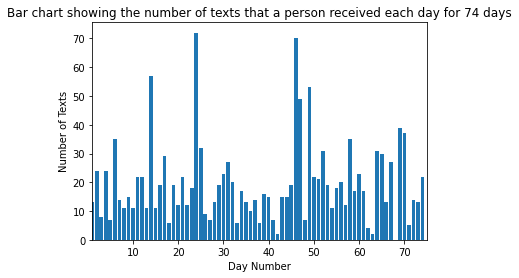

In [4]:
# Now plot the data
plt.title("Bar chart showing the number of texts that a person received each day for 74 days")
plt.ylabel("Number of Texts")
plt.xlabel("Day Number")
plt.bar(data.index,data.NumTexts,width=0.8)
plt.xlim(1,75)
plt.show()

We could model the number of texts that a person receives each day as an observed values of iid $C_i$ ~ Poisson($\lambda$) rvs. However the spikes in the number of texts around Day 25 and Day 45 suggest that we may have 2 different rate parameters. For instance, we might think that there exists some $\tau$ such that for day $t < \tau$, the data can be modelled as observed values of Poisson($\lambda_1$) random variables but for day $t \geq \tau$, the data can be modelled as observed values of Poisson($\lambda_2$) random variables.

In [5]:
# Priors: lambda = lambda_1 if t < tau and lambda = lambda_2 if t >= tau
#         lambda_1 and lambda_2 are positive quantities, so perhaps we could model them as Exponential(alpha) rvs
#         Alternatively, it might be better to model them as arising from different Exponential distributions
#         E[C_i] = lambda and E[lambda] = 1/alpha. 2 methods:
#         (1) A good value for alpha could be the reciprocal of the average number of texts over the 74 days
#         (2) The bar graph seems to suggest a change of rate occurs around midway. 
#             So I could set alpha_1 to be the reciprocal of the average number of texts over the first half the dataset and likewise for alpha_2
#         I attempt both these methods.


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda2]
>Metropolis: [lambda1]
100%|██████████| 20000/20000 [00:08<00:00, 2293.69it/s]
The number of effective samples is smaller than 25% for some parameters.


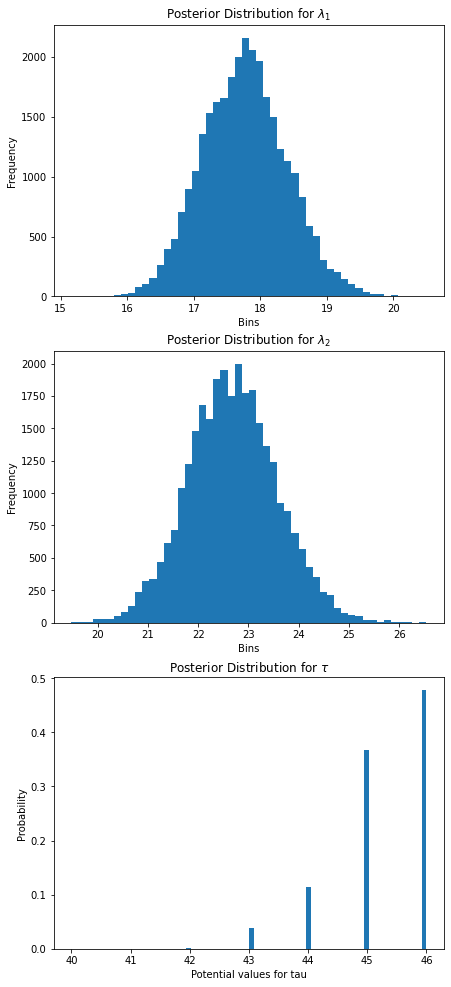

In [6]:
# Method (1) - set alpha equal to the reciprocal of the average number of texts over the 74 days
alpha = 1/data.NumTexts.mean()
t = np.arange(1,len(data.NumTexts)+1)

with pm.Model() as model:
  lambda1 = pm.Exponential("lambda1", alpha)
  lambda2 = pm.Exponential("lambda2", alpha)
  # The switch point can be anywhere between (and including) day 2 and the (n-1)th day.
  # The switch point can't be on day 1 or the final day, since this violates our prior belief that we have 2 different rate parameters
  tau = pm.DiscreteUniform("tau",2,len(data.NumTexts)-1)
  lambdat = pm.math.switch(t < tau, lambda1, lambda2) 

  observed = pm.Poisson("observed",lambdat,observed=data.NumTexts)
  # Use the Metropolis-Hastings algorithm to sample from the posterior
  step = pm.Metropolis()
  trace = pm.sample(15000,tune=5000,step=step)

lambda1_samples = trace["lambda1"]
lambda2_samples = trace["lambda2"]
tau_samples = trace["tau"]

fig = plt.figure(figsize=(7,17))
plt.subplot(311)
plt.title(r"Posterior Distribution for $\lambda_{1}$")
plt.ylabel("Frequency")
plt.xlabel("Bins")
plt.hist(lambda1_samples,bins=50)
plt.subplot(312)
plt.title(r"Posterior Distribution for $\lambda_{2}$")
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.hist(lambda2_samples, bins=50)
plt.subplot(313)
plt.title(r"Posterior Distribution for $\tau$")
plt.xlabel("Potential values for tau")
plt.ylabel("Probability")
plt.hist(tau_samples,bins=len(data.NumTexts),weights=1.0/len(tau_samples)*np.ones_like(tau_samples))
plt.show()

After taking the observed data into account, the most probable value for $\tau$ is 46 with probability just under $\frac{1}{2}$. Likewise, the most probable values for $\lambda_1$ and $\lambda_2$ are around 18 and 23 respectively. However, the posterior may be different if I change the priors so that $\lambda_1$ and $\lambda_2$ are modelled as Exponential random variables with different rate parameters.

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda2]
>Metropolis: [lambda1]
100%|██████████| 20000/20000 [00:08<00:00, 2257.66it/s]
The number of effective samples is smaller than 25% for some parameters.


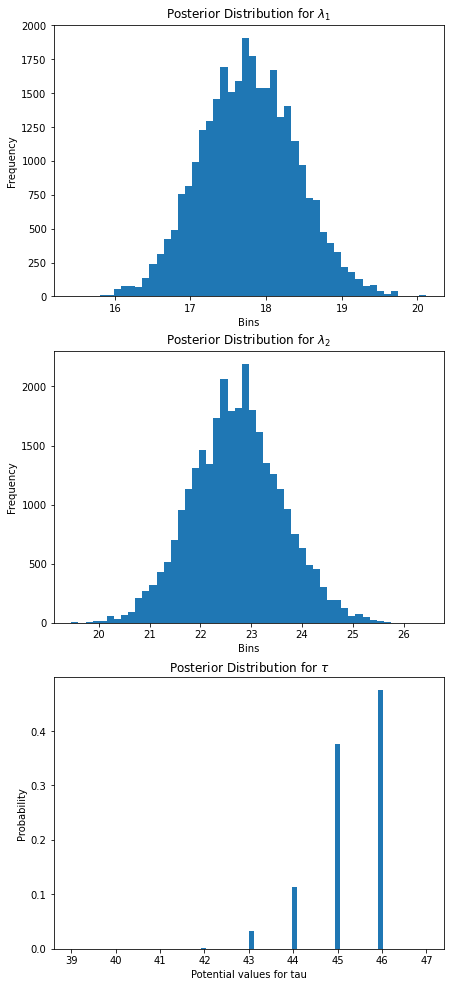

In [7]:
# Method (2) - set alpha_1 equal to the reciprocal of the average number of texts over the first 37 days
#            - set alpha_2 equal to the reciprocal of the average number of texts over the last 37 days
alpha1 = 1/data.NumTexts[:int(0.5*len(data.NumTexts))].mean()
alpha2 = 1/data.NumTexts[int(0.5*len(data.NumTexts)):].mean()
t = np.arange(1,len(data.NumTexts)+1)

with pm.Model() as model:
  lambda1 = pm.Exponential("lambda1", alpha1)
  lambda2 = pm.Exponential("lambda2", alpha2)
  tau = pm.DiscreteUniform("tau",0,len(data.NumTexts))
  lambdat = pm.math.switch(t < tau, lambda1, lambda2) 

  observed = pm.Poisson("observed",lambdat,observed=data.NumTexts)
  # Use the Metropolis-Hastings algorithm to sample from the posterior
  step = pm.Metropolis()
  trace = pm.sample(15000,tune=5000,step=step)

lambda1_samples = trace["lambda1"]
lambda2_samples = trace["lambda2"]
tau_samples = trace["tau"]

fig = plt.figure(figsize=(7,17))
plt.subplot(311)
plt.title(r"Posterior Distribution for $\lambda_{1}$")
plt.ylabel("Frequency")
plt.xlabel("Bins")
plt.hist(lambda1_samples,bins=50)
plt.subplot(312)
plt.title(r"Posterior Distribution for $\lambda_{2}$")
plt.xlabel("Bins")
plt.ylabel("Frequency")
plt.hist(lambda2_samples, bins=50)
plt.subplot(313)
plt.title(r"Posterior Distribution for $\tau$")
plt.xlabel("Potential values for tau")
plt.ylabel("Probability")
plt.hist(tau_samples,bins=len(data.NumTexts),weights=1.0/len(tau_samples)*np.ones_like(tau_samples))
plt.show()

It is quite encouraging to see that there are a lot of similarities, even after changing the priors. The posterior distributions for $\lambda_1$ are remarkably similar, with the modes of both distributions around the 18 mark and with similar variances. The posterior distributions for $\lambda_2$ both have modes around 23. Lastly, our second set of priors result in a distribution for tau that is concentrated in the early/mid-40s in a similar fashion to when both $\lambda_1$ and $\lambda_2$ were initially modelled as Exponential random variables with the same rate parameter.

Now let's ask some questions about our (second) model.


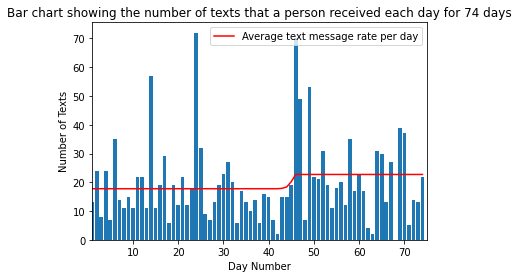

In [24]:
# What is the average text message rate per day?
# Equivalent to asking what the expected value of lambda is per day.
# For each day t, average the number of lambda1 samples if t < tau etc
averagerate = np.zeros(len(t))
for day in t:
  # which of the tau samples are greater/less than day
  taucount = (day < tau_samples)
  averagerate[day-1] = (lambda1_samples[taucount].sum() + lambda2_samples[~taucount].sum())/len(tau_samples)

# Now plot the data
plt.title("Bar chart showing the number of texts that a person received each day for 74 days")
plt.ylabel("Number of Texts")
plt.xlabel("Day Number")
plt.bar(data.index,data.NumTexts,width=0.8)
plt.xlim(1,75)
plt.plot(t,averagerate,color="r",label="Average text message rate per day")
plt.legend(loc="upper right")
plt.show()

What other questions can we ask? We know that the mode of $\lambda_1$ is around 18 and the mode of $\lambda_2$ is around 23, but can we use our samples to be a bit more precise? The central limit theorem suggests that the sampling distributions for $\lambda_1$ and $\lambda_2$ should approximate gaussian distributions, which is supported by the plotted histograms.Firstly, can we support this claim further (qqplot)? Secondly, should we accept this then the theoretical mean of each distribution should be equal to the theoretical modes of each distribution. What are the means of the respective distributions?

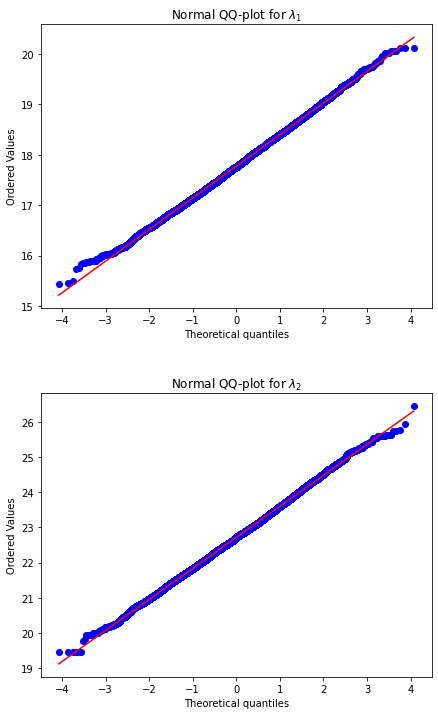

The data points lie very close to the superimposed lines.
Hence, we have sufficient evidence (together with the CLT and histograms) to conclude that the sampling distributions for lambda 1 and lambda2 are normally distributed.

Approximate expected value of lambda1 is 17.77248377189475
Approximate expected value of lambda2 is 22.715965666718482


In [8]:
fig = plt.figure(figsize=(7,12))
fig.add_subplot(211)
stats.probplot(lambda1_samples, dist="norm", plot=plt)
plt.title(r"Normal QQ-plot for $\lambda_1$")
fig.add_subplot(212)
stats.probplot(lambda2_samples, dist="norm", plot=plt)
plt.title(r"Normal QQ-plot for $\lambda_2$")
plt.subplots_adjust(hspace=0.3)
plt.show()

print("The data points lie very close to the superimposed lines.\nHence, we have sufficient evidence (together with the CLT and histograms) to conclude that the sampling distributions for lambda 1 and lambda2 are normally distributed.")
print("\nApproximate expected value of lambda1 is", lambda1_samples.mean())
print("Approximate expected value of lambda2 is", lambda2_samples.mean())

What is the expected percentage increase in text message rates?

In [9]:
print("Expected percentage increase in text message rates?",str(((lambda2_samples/lambda1_samples).mean()-1)*100)+"%")

Expected percentage increase in text message rates? 27.976887456295387%


We can also answer expectation/probability questions about our posteriors using the samples that we have. What is the mean of $\lambda_1$ given that $\tau < 45$?

In [11]:
tau45 = tau_samples < 45
meanconditional = (lambda1_samples[tau45].sum())/tau45.sum()
print("E[lambda1|tau<45] = ", meanconditional)

E[lambda1|tau<45] =  17.843120627336095
